In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[1:]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
del cm_target[5]
del cm_target[3]
del cm_target[1]
del cm_target[0]

In [11]:
cm_target

['case2cm_blade1.csv',
 'case5cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (60000, 2)
Dimension - heights of Gurney flaps:  (60000, 1)
Dimension - inclination(beta):  (60000, 1)
Dimension - x:  (60000, 3)
Dimension - y:  (60000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.000e+00, 2.000e-04, 4.000e-04, ..., 9.994e-01, 9.996e-01,
       9.998e-01])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221229\\12beta"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-6, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
42/42 [==============================] - 2s 11ms/step - loss: 0.1091 - rmse: 0.3301 - val_loss: 0.0668 - val_rmse: 0.2582 - lr: 1.0000e-04
Epoch 2/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0621 - rmse: 0.2491 - val_loss: 0.0618 - val_rmse: 0.2485 - lr: 1.0000e-04
Epoch 3/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0611 - rmse: 0.2470 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 4/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0607 - rmse: 0.2461 - val_loss: 0.0609 - val_rmse: 0.2465 - lr: 1.0000e-04
Epoch 5/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0602 - rmse: 0.2452 - val_loss: 0.0603 - val_rmse: 0.2454 - lr: 1.0000e-04
Epoch 6/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0598 - rmse: 0.2443 - val_loss: 0.0600 - val_rmse: 0.2447 - lr: 1.0000e-04
Epoch 7/10000
42/42 [==============================] - 0s 5ms/step - loss: 0.0594 - rms

42/42 [==============================] - 0s 8ms/step - loss: 0.0392 - rmse: 0.1978 - val_loss: 0.0401 - val_rmse: 0.2001 - lr: 1.0000e-04
Epoch 55/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0418 - val_rmse: 0.2042 - lr: 1.0000e-04
Epoch 56/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0388 - rmse: 0.1967 - val_loss: 0.0415 - val_rmse: 0.2034 - lr: 1.0000e-04
Epoch 57/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0385 - rmse: 0.1959 - val_loss: 0.0381 - val_rmse: 0.1950 - lr: 1.0000e-04
Epoch 58/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0372 - rmse: 0.1927 - val_loss: 0.0379 - val_rmse: 0.1944 - lr: 1.0000e-04
Epoch 59/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0368 - rmse: 0.1915 - val_loss: 0.0370 - val_rmse: 0.1922 - lr: 1.0000e-04
Epoch 60/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0365 - rmse: 0.1909

42/42 [==============================] - 0s 7ms/step - loss: 0.0194 - rmse: 0.1389 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 108/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0182 - rmse: 0.1344 - val_loss: 0.0175 - val_rmse: 0.1320 - lr: 1.0000e-04
Epoch 109/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0177 - val_rmse: 0.1326 - lr: 1.0000e-04
Epoch 110/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0176 - rmse: 0.1322 - val_loss: 0.0168 - val_rmse: 0.1292 - lr: 1.0000e-04
Epoch 111/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0177 - rmse: 0.1329 - val_loss: 0.0166 - val_rmse: 0.1286 - lr: 1.0000e-04
Epoch 112/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0164 - val_rmse: 0.1277 - lr: 1.0000e-04
Epoch 113/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0172 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0102 - rmse: 0.1003 - val_loss: 0.0101 - val_rmse: 0.0999 - lr: 1.0000e-04
Epoch 161/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0100 - rmse: 0.0994 - val_loss: 0.0098 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 162/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0098 - rmse: 0.0988 - val_loss: 0.0095 - val_rmse: 0.0971 - lr: 1.0000e-04
Epoch 163/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 164/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0138 - rmse: 0.1171 - val_loss: 0.0147 - val_rmse: 0.1208 - lr: 1.0000e-04
Epoch 165/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 0.1097 - val_loss: 0.0100 - val_rmse: 0.0993 - lr: 1.0000e-04
Epoch 166/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0101 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0076 - rmse: 0.0868 - val_loss: 0.0071 - val_rmse: 0.0839 - lr: 1.0000e-04
Epoch 214/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0081 - val_rmse: 0.0892 - lr: 1.0000e-04
Epoch 215/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0070 - rmse: 0.0829 - val_loss: 0.0069 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 216/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0191 - val_rmse: 0.1380 - lr: 1.0000e-04
Epoch 217/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0125 - rmse: 0.1112 - val_loss: 0.0074 - val_rmse: 0.0856 - lr: 1.0000e-04
Epoch 218/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0071 - rmse: 0.0836 - val_loss: 0.0068 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 219/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0069 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0054 - val_rmse: 0.0729 - lr: 1.0000e-04
Epoch 267/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0079 - rmse: 0.0886 - val_loss: 0.0094 - val_rmse: 0.0965 - lr: 1.0000e-04
Epoch 268/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0062 - rmse: 0.0784 - val_loss: 0.0069 - val_rmse: 0.0827 - lr: 1.0000e-04
Epoch 269/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 0.0733 - val_loss: 0.0055 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 270/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 271/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0058 - rmse: 0.0756 - val_loss: 0.0065 - val_rmse: 0.0797 - lr: 1.0000e-04
Epoch 272/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0258 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 320/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0086 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 321/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0078 - rmse: 0.0878 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 322/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0072 - rmse: 0.0844 - val_loss: 0.0064 - val_rmse: 0.0795 - lr: 1.0000e-04
Epoch 323/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0060 - rmse: 0.0769 - val_loss: 0.0058 - val_rmse: 0.0753 - lr: 1.0000e-04
Epoch 324/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0056 - rmse: 0.0742 - val_loss: 0.0056 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 325/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0053 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0727 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 373/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0045 - rmse: 0.0661 - val_loss: 0.0036 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 374/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0040 - rmse: 0.0624 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 375/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0039 - rmse: 0.0615 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 376/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 377/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 378/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 426/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 427/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 1.0000e-04
Epoch 428/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 0.0552 - val_loss: 0.0036 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 429/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0537 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 430/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0032 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 431/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0047 - rmse: 

42/42 [==============================] - 0s 8ms/step - loss: 0.0026 - rmse: 0.0496 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 1.0000e-04
Epoch 479/10000
42/42 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0535 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 480/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 481/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0484 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 482/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0030 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 483/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0508 - val_loss: 0.0040 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 484/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 532/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 533/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 534/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0018 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 535/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 536/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0045 - rmse: 0.0660 - val_loss: 0.0032 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 537/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0024 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 585/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 586/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0040 - rmse: 0.0622 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 587/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0017 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 588/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 589/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0430 - val_loss: 0.0017 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 590/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0478 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 638/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0369 - val_loss: 0.0014 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 639/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 0.0597 - val_loss: 0.0025 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 640/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0455 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 641/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0368 - val_loss: 0.0014 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 642/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0397 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 643/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 691/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0417 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 692/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0506 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 693/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0014 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 694/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 695/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0372 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 696/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 

42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0324 - val_loss: 9.3821e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 744/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 745/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0406 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 746/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0028 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 747/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 748/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0014 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 749/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0042 - rm

42/42 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 797/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 798/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0396 - val_loss: 0.0010 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 799/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 800/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0022 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 801/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0392 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 802/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 

Epoch 849/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 7.9448e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 850/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0396 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 851/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 9.5590e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 852/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 853/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0369 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 854/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0433 - val_loss: 0.0011 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 855/10000
42/42 [==============================] - 0s 7ms/step

42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 7.2943e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 902/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.1625e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 903/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.1287e-04 - rmse: 0.0282 - val_loss: 8.8831e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 904/10000
42/42 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 9.5861e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 905/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.6804e-04 - rmse: 0.0274 - val_loss: 7.2984e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 906/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0038 - rmse: 0.0603 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 907/10000
42/42 [==============================] - 0s 7ms/

42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 954/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0339 - val_loss: 6.8141e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 955/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.9745e-04 - rmse: 0.0261 - val_loss: 7.2323e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 956/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0536 - val_loss: 0.0014 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 957/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.4148e-04 - rmse: 0.0269 - val_loss: 7.1535e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 958/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 7.6445e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 959/10000
42/42 [==============================] - 0s 7ms/step

42/42 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0341 - val_loss: 6.5734e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 1006/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0484 - val_loss: 0.0036 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 1007/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0306 - val_loss: 6.2551e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1008/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.4960e-04 - rmse: 0.0288 - val_loss: 8.6185e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 1009/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0421 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 1010/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.7234e-04 - rmse: 0.0292 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 1011/10000
42/42 [==============================] - 0s 7ms/st

Epoch 1057/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0366 - val_loss: 7.1077e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1058/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 1059/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.2620e-04 - rmse: 0.0284 - val_loss: 6.2625e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1060/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.7338e-04 - rmse: 0.0292 - val_loss: 5.9006e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1061/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 1.0000e-04
Epoch 1062/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.4128e-04 - rmse: 0.0269 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 1063/10000
42/42 [======================

42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0397 - val_loss: 7.9965e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 1109/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0355 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 1110/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.8461e-04 - rmse: 0.0277 - val_loss: 0.0021 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 1111/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 7.0997e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1112/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.7428e-04 - rmse: 0.0275 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 1113/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0431 - val_loss: 0.0014 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 1114/10000
42/42 [==============================] - 0s 7ms/step -

Epoch 1160/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 5.5701e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1161/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0352 - val_loss: 8.1971e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1162/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.5020e-04 - rmse: 0.0251 - val_loss: 9.7496e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 1163/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0392 - val_loss: 6.7246e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 1164/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 9.3686e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 1165/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 9.9745e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 1166/10000
42/42 [==================

42/42 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0454 - val_loss: 9.9913e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 1212/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.3188e-04 - rmse: 0.0226 - val_loss: 0.0016 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 1213/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 1214/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0323 - val_loss: 6.5491e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 1215/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.8970e-04 - rmse: 0.0277 - val_loss: 6.3065e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 1216/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 6.1544e-04 - val_rmse: 0.0222 - lr: 1.0000e-04
Epoch 1217/10000
42/42 [==============================] - 0s 7m

42/42 [==============================] - 0s 7ms/step - loss: 9.8920e-04 - rmse: 0.0295 - val_loss: 7.4473e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 1263/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.9621e-04 - rmse: 0.0240 - val_loss: 6.4407e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 1264/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0042 - val_rmse: 0.0638 - lr: 1.0000e-04
Epoch 1265/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0327 - val_loss: 6.3461e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 1266/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.0728e-04 - rmse: 0.0242 - val_loss: 4.9930e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1267/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0465 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 1268/10000
42/42 [==============================] - 0

42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0322 - val_loss: 7.2391e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1314/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.4821e-04 - rmse: 0.0250 - val_loss: 0.0010 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 1315/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 5.0332e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1316/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.9164e-04 - rmse: 0.0295 - val_loss: 5.8503e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1317/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.7415e-04 - rmse: 0.0255 - val_loss: 7.3009e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 1318/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.8527e-04 - rmse: 0.0257 - val_loss: 5.6515e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 1319/10000
42/42 [===========================

42/42 [==============================] - 0s 7ms/step - loss: 6.3651e-04 - rmse: 0.0227 - val_loss: 5.4124e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1365/10000
42/42 [==============================] - 0s 7ms/step - loss: 5.6667e-04 - rmse: 0.0211 - val_loss: 7.4171e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 1366/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.7213e-04 - rmse: 0.0255 - val_loss: 5.0109e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1367/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.5559e-04 - rmse: 0.0271 - val_loss: 4.7838e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 1368/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.6042e-04 - rmse: 0.0272 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 1369/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.3752e-04 - rmse: 0.0248 - val_loss: 5.6582e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 1370/10000
42/42 [===================

42/42 [==============================] - 0s 7ms/step - loss: 7.9597e-04 - rmse: 0.0259 - val_loss: 0.0018 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 1416/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.1725e-04 - rmse: 0.0263 - val_loss: 5.8112e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 1417/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 1418/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.0391e-04 - rmse: 0.0279 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 1419/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.4096e-04 - rmse: 0.0268 - val_loss: 5.3940e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1420/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0407 - val_loss: 0.0013 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 1421/10000
42/42 [==============================] - 0s 7m

42/42 [==============================] - 0s 7ms/step - loss: 9.0097e-04 - rmse: 0.0279 - val_loss: 6.8627e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 1467/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.0515e-04 - rmse: 0.0219 - val_loss: 4.3019e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 1468/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 5.2279e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1469/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.0949e-04 - rmse: 0.0242 - val_loss: 0.0017 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 1470/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.5075e-04 - rmse: 0.0250 - val_loss: 4.5549e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1471/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0325 - val_loss: 0.0039 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 1472/10000
42/42 [==============================]

Epoch 1517/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.7590e-04 - rmse: 0.0255 - val_loss: 4.5337e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 1518/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.5690e-04 - rmse: 0.0231 - val_loss: 7.4975e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 1519/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.4254e-04 - rmse: 0.0286 - val_loss: 5.3974e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1520/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 6.2578e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 1521/10000
42/42 [==============================] - 0s 7ms/step - loss: 5.8982e-04 - rmse: 0.0216 - val_loss: 7.7841e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 1522/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0337 - val_loss: 8.7779e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 1523/10000
42/42 [======

Epoch 1568/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.5792e-04 - rmse: 0.0252 - val_loss: 9.8954e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 1569/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.7424e-04 - rmse: 0.0274 - val_loss: 4.6698e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 1570/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.3028e-04 - rmse: 0.0284 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 1571/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.9536e-04 - rmse: 0.0278 - val_loss: 5.8617e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1572/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.1776e-04 - rmse: 0.0244 - val_loss: 7.8988e-04 - val_rmse: 0.0258 - lr: 1.0000e-04
Epoch 1573/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 1574/10000
42/42 [==========

Epoch 1619/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.0306e-04 - rmse: 0.0260 - val_loss: 5.9600e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1620/10000
42/42 [==============================] - 0s 7ms/step - loss: 5.2188e-04 - rmse: 0.0199 - val_loss: 4.3951e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 1621/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.2647e-04 - rmse: 0.0265 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 1622/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0015 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 1623/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.3602e-04 - rmse: 0.0267 - val_loss: 4.4824e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 1624/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.5405e-04 - rmse: 0.0230 - val_loss: 7.1797e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1625/10000
42/42 [==========

Epoch 1670/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.6728e-04 - rmse: 0.0233 - val_loss: 7.2734e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1671/10000
42/42 [==============================] - 0s 7ms/step - loss: 8.0130e-04 - rmse: 0.0260 - val_loss: 0.0012 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 1672/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.0350e-04 - rmse: 0.0219 - val_loss: 4.5733e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1673/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.0842e-04 - rmse: 0.0241 - val_loss: 3.9708e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 1674/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.1937e-04 - rmse: 0.0222 - val_loss: 4.9634e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 1675/10000
42/42 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 6.9548e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 1676/10000
42/42 [======

Epoch 1721/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.5310e-04 - rmse: 0.0230 - val_loss: 9.2095e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 1722/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.9439e-04 - rmse: 0.0259 - val_loss: 3.7844e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1723/10000
42/42 [==============================] - 0s 7ms/step - loss: 9.0043e-04 - rmse: 0.0278 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 1724/10000
42/42 [==============================] - 0s 7ms/step - loss: 7.1375e-04 - rmse: 0.0242 - val_loss: 5.5075e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 1725/10000
42/42 [==============================] - 0s 7ms/step - loss: 5.9901e-04 - rmse: 0.0217 - val_loss: 6.6278e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 1726/10000
42/42 [==============================] - 0s 7ms/step - loss: 6.0559e-04 - rmse: 0.0219 - val_loss: 4.0597e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1727/10000
42/42 [==

Epoch 1771/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0610e-04 - rmse: 0.0134 - val_loss: 3.1607e-04 - val_rmse: 0.0138 - lr: 1.0000e-05
Epoch 1772/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0570e-04 - rmse: 0.0134 - val_loss: 3.1381e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1773/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0596e-04 - rmse: 0.0134 - val_loss: 3.1505e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1774/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0542e-04 - rmse: 0.0134 - val_loss: 3.1486e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1775/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0674e-04 - rmse: 0.0134 - val_loss: 3.1353e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1776/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0527e-04 - rmse: 0.0134 - val_loss: 3.1467e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1777/10000
42/42

42/42 [==============================] - 0s 7ms/step - loss: 3.0510e-04 - rmse: 0.0134 - val_loss: 3.1362e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1822/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0414e-04 - rmse: 0.0133 - val_loss: 3.1111e-04 - val_rmse: 0.0136 - lr: 1.0000e-05
Epoch 1823/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0120e-04 - rmse: 0.0132 - val_loss: 3.1460e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1824/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0257e-04 - rmse: 0.0133 - val_loss: 3.1531e-04 - val_rmse: 0.0138 - lr: 1.0000e-05
Epoch 1825/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0988e-04 - rmse: 0.0136 - val_loss: 3.2508e-04 - val_rmse: 0.0141 - lr: 1.0000e-05
Epoch 1826/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0624e-04 - rmse: 0.0134 - val_loss: 3.1059e-04 - val_rmse: 0.0136 - lr: 1.0000e-05
Epoch 1827/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.9796e-04 - rmse: 0.0131 - val_loss: 3.1346e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 1872/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0258e-04 - rmse: 0.0133 - val_loss: 3.0305e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 1873/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0242e-04 - rmse: 0.0133 - val_loss: 2.9814e-04 - val_rmse: 0.0131 - lr: 1.0000e-05
Epoch 1874/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0014e-04 - rmse: 0.0132 - val_loss: 3.0078e-04 - val_rmse: 0.0132 - lr: 1.0000e-05
Epoch 1875/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.9582e-04 - rmse: 0.0130 - val_loss: 3.1569e-04 - val_rmse: 0.0138 - lr: 1.0000e-05
Epoch 1876/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0734e-04 - rmse: 0.0135 - val_loss: 3.0865e-04 - val_rmse: 0.0135 - lr: 1.0000e-05
Epoch 1877/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.9446e-04 - rmse: 0.0130 - val_loss: 2.9079e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 1922/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8985e-04 - rmse: 0.0128 - val_loss: 2.9605e-04 - val_rmse: 0.0130 - lr: 1.0000e-05
Epoch 1923/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8949e-04 - rmse: 0.0128 - val_loss: 3.0127e-04 - val_rmse: 0.0132 - lr: 1.0000e-05
Epoch 1924/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.9231e-04 - rmse: 0.0129 - val_loss: 3.0281e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 1925/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8675e-04 - rmse: 0.0127 - val_loss: 2.9149e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 1926/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8969e-04 - rmse: 0.0128 - val_loss: 2.9074e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 1927/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.8788e-04 - rmse: 0.0127 - val_loss: 2.8499e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 1972/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8614e-04 - rmse: 0.0127 - val_loss: 3.0048e-04 - val_rmse: 0.0132 - lr: 1.0000e-05
Epoch 1973/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8461e-04 - rmse: 0.0126 - val_loss: 2.8288e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 1974/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8244e-04 - rmse: 0.0125 - val_loss: 2.9160e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 1975/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8295e-04 - rmse: 0.0125 - val_loss: 2.8977e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 1976/10000
42/42 [==============================] - 0s 7ms/step - loss: 3.0128e-04 - rmse: 0.0132 - val_loss: 2.8491e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 1977/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.8523e-04 - rmse: 0.0126 - val_loss: 2.8604e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2022/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8141e-04 - rmse: 0.0125 - val_loss: 2.9997e-04 - val_rmse: 0.0132 - lr: 1.0000e-05
Epoch 2023/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8468e-04 - rmse: 0.0126 - val_loss: 2.8231e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2024/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8799e-04 - rmse: 0.0127 - val_loss: 2.8217e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2025/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.8228e-04 - rmse: 0.0125 - val_loss: 2.8123e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2026/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7580e-04 - rmse: 0.0122 - val_loss: 2.8642e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2027/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.7125e-04 - rmse: 0.0121 - val_loss: 2.8142e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2072/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7482e-04 - rmse: 0.0122 - val_loss: 2.9339e-04 - val_rmse: 0.0130 - lr: 1.0000e-05
Epoch 2073/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7543e-04 - rmse: 0.0122 - val_loss: 2.7185e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2074/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7728e-04 - rmse: 0.0123 - val_loss: 2.8216e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2075/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7762e-04 - rmse: 0.0123 - val_loss: 2.8267e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2076/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6831e-04 - rmse: 0.0119 - val_loss: 2.8173e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2077/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.6581e-04 - rmse: 0.0118 - val_loss: 2.6817e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2122/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6558e-04 - rmse: 0.0118 - val_loss: 2.8056e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2123/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6532e-04 - rmse: 0.0118 - val_loss: 2.8293e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2124/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.7558e-04 - rmse: 0.0123 - val_loss: 2.8808e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 2125/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6766e-04 - rmse: 0.0119 - val_loss: 2.8827e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 2126/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.7033e-04 - rmse: 0.0120 - val_loss: 2.6754e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2127/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.8802e-04 - rmse: 0.0128 - val_loss: 3.0712e-04 - val_rmse: 0.0135 - lr: 1.0000e-05
Epoch 2172/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6170e-04 - rmse: 0.0117 - val_loss: 2.6000e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2173/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6604e-04 - rmse: 0.0119 - val_loss: 2.6246e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2174/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.5946e-04 - rmse: 0.0116 - val_loss: 2.6742e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2175/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6411e-04 - rmse: 0.0118 - val_loss: 2.6090e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2176/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6633e-04 - rmse: 0.0119 - val_loss: 2.9737e-04 - val_rmse: 0.0131 - lr: 1.0000e-05
Epoch 2177/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.6332e-04 - rmse: 0.0118 - val_loss: 2.7742e-04 - val_rmse: 0.0123 - lr: 1.0000e-05
Epoch 2222/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6182e-04 - rmse: 0.0117 - val_loss: 2.9034e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2223/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6961e-04 - rmse: 0.0120 - val_loss: 2.6120e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2224/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5400e-04 - rmse: 0.0114 - val_loss: 2.5848e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2225/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5398e-04 - rmse: 0.0113 - val_loss: 2.7081e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2226/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6149e-04 - rmse: 0.0117 - val_loss: 2.6969e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2227/10000
42/42 [===============

42/42 [==============================] - 0s 6ms/step - loss: 2.5536e-04 - rmse: 0.0114 - val_loss: 2.5228e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2272/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5914e-04 - rmse: 0.0116 - val_loss: 2.5682e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2273/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6844e-04 - rmse: 0.0120 - val_loss: 2.6754e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2274/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6140e-04 - rmse: 0.0117 - val_loss: 2.6023e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2275/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6981e-04 - rmse: 0.0120 - val_loss: 2.5955e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2276/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.5723e-04 - rmse: 0.0115 - val_loss: 2.5664e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2277/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.5204e-04 - rmse: 0.0113 - val_loss: 2.4940e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2322/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.5304e-04 - rmse: 0.0113 - val_loss: 2.5366e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2323/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4677e-04 - rmse: 0.0110 - val_loss: 2.5080e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2324/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4892e-04 - rmse: 0.0111 - val_loss: 2.7575e-04 - val_rmse: 0.0123 - lr: 1.0000e-05
Epoch 2325/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.6851e-04 - rmse: 0.0120 - val_loss: 2.8081e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2326/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5370e-04 - rmse: 0.0114 - val_loss: 2.7106e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2327/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.4356e-04 - rmse: 0.0109 - val_loss: 2.4776e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 2372/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4741e-04 - rmse: 0.0111 - val_loss: 2.8598e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2373/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5554e-04 - rmse: 0.0114 - val_loss: 2.5205e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2374/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4409e-04 - rmse: 0.0109 - val_loss: 2.4428e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2375/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.5891e-04 - rmse: 0.0116 - val_loss: 2.5123e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2376/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4255e-04 - rmse: 0.0109 - val_loss: 2.4484e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2377/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.4487e-04 - rmse: 0.0110 - val_loss: 2.5574e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2422/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4800e-04 - rmse: 0.0111 - val_loss: 2.4662e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2423/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6138e-04 - rmse: 0.0117 - val_loss: 2.4873e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 2424/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4821e-04 - rmse: 0.0111 - val_loss: 2.5994e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2425/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5112e-04 - rmse: 0.0113 - val_loss: 2.6456e-04 - val_rmse: 0.0118 - lr: 1.0000e-05
Epoch 2426/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4808e-04 - rmse: 0.0111 - val_loss: 2.8224e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 2427/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.4746e-04 - rmse: 0.0111 - val_loss: 2.4731e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 2472/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4110e-04 - rmse: 0.0108 - val_loss: 2.4064e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2473/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4880e-04 - rmse: 0.0112 - val_loss: 2.4669e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 2474/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.5216e-04 - rmse: 0.0113 - val_loss: 2.4212e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2475/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3991e-04 - rmse: 0.0107 - val_loss: 2.6776e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2476/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4662e-04 - rmse: 0.0111 - val_loss: 2.4920e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2477/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.4170e-04 - rmse: 0.0108 - val_loss: 2.8425e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2522/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6100e-04 - rmse: 0.0117 - val_loss: 2.6267e-04 - val_rmse: 0.0118 - lr: 1.0000e-05
Epoch 2523/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4865e-04 - rmse: 0.0112 - val_loss: 2.6080e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2524/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3969e-04 - rmse: 0.0107 - val_loss: 2.8441e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2525/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4588e-04 - rmse: 0.0110 - val_loss: 2.5565e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2526/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4128e-04 - rmse: 0.0108 - val_loss: 2.4156e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2527/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.4380e-04 - rmse: 0.0109 - val_loss: 3.4597e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 2572/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6669e-04 - rmse: 0.0119 - val_loss: 3.1017e-04 - val_rmse: 0.0136 - lr: 1.0000e-05
Epoch 2573/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.6722e-04 - rmse: 0.0120 - val_loss: 2.3858e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2574/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3325e-04 - rmse: 0.0105 - val_loss: 2.4056e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2575/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4246e-04 - rmse: 0.0109 - val_loss: 2.4132e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2576/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4369e-04 - rmse: 0.0109 - val_loss: 3.1689e-04 - val_rmse: 0.0139 - lr: 1.0000e-05
Epoch 2577/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3549e-04 - rmse: 0.0106 - val_loss: 2.5336e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2622/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4080e-04 - rmse: 0.0108 - val_loss: 2.3316e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 2623/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3357e-04 - rmse: 0.0105 - val_loss: 2.3824e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2624/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4266e-04 - rmse: 0.0109 - val_loss: 2.3965e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2625/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3683e-04 - rmse: 0.0106 - val_loss: 2.5504e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 2626/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4421e-04 - rmse: 0.0110 - val_loss: 2.5207e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2627/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3154e-04 - rmse: 0.0104 - val_loss: 2.3879e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2672/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4461e-04 - rmse: 0.0110 - val_loss: 2.3514e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 2673/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2882e-04 - rmse: 0.0103 - val_loss: 2.3972e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2674/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3244e-04 - rmse: 0.0104 - val_loss: 2.5146e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2675/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3333e-04 - rmse: 0.0105 - val_loss: 2.3293e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 2676/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3023e-04 - rmse: 0.0103 - val_loss: 2.3097e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 2677/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3336e-04 - rmse: 0.0105 - val_loss: 2.3758e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2722/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3769e-04 - rmse: 0.0107 - val_loss: 2.7277e-04 - val_rmse: 0.0122 - lr: 1.0000e-05
Epoch 2723/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3126e-04 - rmse: 0.0104 - val_loss: 2.2733e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 2724/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3133e-04 - rmse: 0.0104 - val_loss: 2.4843e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2725/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4946e-04 - rmse: 0.0112 - val_loss: 2.9689e-04 - val_rmse: 0.0132 - lr: 1.0000e-05
Epoch 2726/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3219e-04 - rmse: 0.0104 - val_loss: 2.5934e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2727/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2500e-04 - rmse: 0.0101 - val_loss: 2.2654e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 2772/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3032e-04 - rmse: 0.0103 - val_loss: 2.4820e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2773/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2697e-04 - rmse: 0.0102 - val_loss: 2.4118e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2774/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2827e-04 - rmse: 0.0102 - val_loss: 2.4128e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2775/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3411e-04 - rmse: 0.0105 - val_loss: 2.4431e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2776/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2812e-04 - rmse: 0.0102 - val_loss: 2.2293e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 2777/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3952e-04 - rmse: 0.0108 - val_loss: 2.4127e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2822/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3159e-04 - rmse: 0.0104 - val_loss: 2.2988e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 2823/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2096e-04 - rmse: 0.0099 - val_loss: 2.2907e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 2824/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2828e-04 - rmse: 0.0103 - val_loss: 2.2623e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 2825/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2625e-04 - rmse: 0.0102 - val_loss: 2.3508e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 2826/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2923e-04 - rmse: 0.0103 - val_loss: 2.6719e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2827/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3654e-04 - rmse: 0.0107 - val_loss: 2.6810e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2872/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.4740e-04 - rmse: 0.0112 - val_loss: 2.3121e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 2873/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2025e-04 - rmse: 0.0099 - val_loss: 2.1894e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 2874/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3608e-04 - rmse: 0.0106 - val_loss: 2.2350e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 2875/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3602e-04 - rmse: 0.0106 - val_loss: 2.2211e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 2876/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2435e-04 - rmse: 0.0101 - val_loss: 2.2088e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 2877/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2858e-04 - rmse: 0.0103 - val_loss: 2.1932e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 2922/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3089e-04 - rmse: 0.0104 - val_loss: 2.4958e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2923/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2692e-04 - rmse: 0.0102 - val_loss: 2.3098e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 2924/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2040e-04 - rmse: 0.0099 - val_loss: 2.2997e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 2925/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2208e-04 - rmse: 0.0100 - val_loss: 2.2586e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 2926/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2443e-04 - rmse: 0.0101 - val_loss: 2.3162e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 2927/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2050e-04 - rmse: 0.0099 - val_loss: 2.2595e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 2972/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2038e-04 - rmse: 0.0099 - val_loss: 2.5210e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2973/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3097e-04 - rmse: 0.0104 - val_loss: 2.2485e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 2974/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2429e-04 - rmse: 0.0101 - val_loss: 2.2628e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 2975/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2228e-04 - rmse: 0.0100 - val_loss: 2.3618e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2976/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1921e-04 - rmse: 0.0098 - val_loss: 2.1997e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 2977/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2020e-04 - rmse: 0.0099 - val_loss: 2.2255e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3022/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1846e-04 - rmse: 0.0098 - val_loss: 2.1466e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3023/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1657e-04 - rmse: 0.0097 - val_loss: 2.1991e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3024/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3080e-04 - rmse: 0.0104 - val_loss: 2.1595e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3025/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1569e-04 - rmse: 0.0097 - val_loss: 2.2018e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3026/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1662e-04 - rmse: 0.0097 - val_loss: 2.2200e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3027/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2466e-04 - rmse: 0.0101 - val_loss: 2.2592e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3072/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2713e-04 - rmse: 0.0102 - val_loss: 2.1341e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3073/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1891e-04 - rmse: 0.0098 - val_loss: 2.1999e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3074/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1437e-04 - rmse: 0.0096 - val_loss: 2.1306e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3075/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1591e-04 - rmse: 0.0097 - val_loss: 2.1680e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3076/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1593e-04 - rmse: 0.0097 - val_loss: 2.4382e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 3077/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.1687e-04 - rmse: 0.0097 - val_loss: 2.5314e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 3122/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2909e-04 - rmse: 0.0103 - val_loss: 2.1437e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3123/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1491e-04 - rmse: 0.0096 - val_loss: 2.1918e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3124/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1768e-04 - rmse: 0.0098 - val_loss: 2.5736e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 3125/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3353e-04 - rmse: 0.0106 - val_loss: 2.1288e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3126/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1521e-04 - rmse: 0.0096 - val_loss: 2.2696e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3127/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.2594e-04 - rmse: 0.0102 - val_loss: 2.3894e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 3172/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1720e-04 - rmse: 0.0098 - val_loss: 2.1649e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3173/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1786e-04 - rmse: 0.0098 - val_loss: 2.1551e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3174/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1586e-04 - rmse: 0.0097 - val_loss: 2.2459e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 3175/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1999e-04 - rmse: 0.0099 - val_loss: 2.3841e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 3176/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1334e-04 - rmse: 0.0096 - val_loss: 2.2509e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3177/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0975e-04 - rmse: 0.0094 - val_loss: 2.1091e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3222/10000
42/42 [==============================] - 0s 8ms/step - loss: 2.1524e-04 - rmse: 0.0097 - val_loss: 2.2856e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3223/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0998e-04 - rmse: 0.0094 - val_loss: 2.1345e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3224/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1103e-04 - rmse: 0.0094 - val_loss: 2.1506e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3225/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1339e-04 - rmse: 0.0096 - val_loss: 2.0856e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 3226/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0708e-04 - rmse: 0.0092 - val_loss: 2.4243e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 3227/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.1399e-04 - rmse: 0.0096 - val_loss: 2.1189e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3272/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0743e-04 - rmse: 0.0093 - val_loss: 2.1819e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3273/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1370e-04 - rmse: 0.0096 - val_loss: 2.1482e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3274/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1470e-04 - rmse: 0.0096 - val_loss: 2.2731e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3275/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2697e-04 - rmse: 0.0103 - val_loss: 2.6318e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 3276/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2415e-04 - rmse: 0.0101 - val_loss: 2.1183e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3277/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.3342e-04 - rmse: 0.0106 - val_loss: 2.1623e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3322/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1336e-04 - rmse: 0.0096 - val_loss: 2.4547e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 3323/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2166e-04 - rmse: 0.0100 - val_loss: 2.1956e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3324/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0898e-04 - rmse: 0.0094 - val_loss: 2.0677e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3325/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1598e-04 - rmse: 0.0097 - val_loss: 2.0922e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3326/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1683e-04 - rmse: 0.0098 - val_loss: 2.1375e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3327/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.1203e-04 - rmse: 0.0095 - val_loss: 2.1433e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3372/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0277e-04 - rmse: 0.0090 - val_loss: 2.0956e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3373/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1160e-04 - rmse: 0.0095 - val_loss: 2.0532e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3374/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2425e-04 - rmse: 0.0101 - val_loss: 2.4718e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 3375/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2952e-04 - rmse: 0.0104 - val_loss: 2.1938e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3376/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2238e-04 - rmse: 0.0101 - val_loss: 2.1240e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3377/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.1530e-04 - rmse: 0.0097 - val_loss: 2.2927e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 3422/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1157e-04 - rmse: 0.0095 - val_loss: 2.1014e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3423/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0522e-04 - rmse: 0.0092 - val_loss: 2.1136e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3424/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1046e-04 - rmse: 0.0094 - val_loss: 2.0422e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3425/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0826e-04 - rmse: 0.0093 - val_loss: 2.1551e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3426/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0778e-04 - rmse: 0.0093 - val_loss: 2.2955e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 3427/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0433e-04 - rmse: 0.0091 - val_loss: 2.0156e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 3472/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0559e-04 - rmse: 0.0092 - val_loss: 2.0111e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3473/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2581e-04 - rmse: 0.0102 - val_loss: 2.0670e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 3474/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.3217e-04 - rmse: 0.0105 - val_loss: 2.0685e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 3475/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1532e-04 - rmse: 0.0097 - val_loss: 2.1422e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3476/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0894e-04 - rmse: 0.0094 - val_loss: 2.2240e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 3477/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0479e-04 - rmse: 0.0092 - val_loss: 2.2580e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3522/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0227e-04 - rmse: 0.0090 - val_loss: 2.1386e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3523/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1183e-04 - rmse: 0.0095 - val_loss: 2.3130e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 3524/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0542e-04 - rmse: 0.0092 - val_loss: 2.0864e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3525/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0468e-04 - rmse: 0.0092 - val_loss: 2.0439e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3526/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0646e-04 - rmse: 0.0093 - val_loss: 2.0496e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3527/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0942e-04 - rmse: 0.0094 - val_loss: 2.1188e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3572/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0270e-04 - rmse: 0.0091 - val_loss: 2.0347e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3573/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0117e-04 - rmse: 0.0090 - val_loss: 2.0434e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3574/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0646e-04 - rmse: 0.0093 - val_loss: 2.0037e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3575/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9760e-04 - rmse: 0.0088 - val_loss: 1.9890e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3576/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0533e-04 - rmse: 0.0092 - val_loss: 2.0530e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3577/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0761e-04 - rmse: 0.0093 - val_loss: 2.1087e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3622/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0194e-04 - rmse: 0.0090 - val_loss: 1.9875e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3623/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0959e-04 - rmse: 0.0094 - val_loss: 2.1900e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3624/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0838e-04 - rmse: 0.0094 - val_loss: 2.2258e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 3625/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0575e-04 - rmse: 0.0092 - val_loss: 2.1063e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3626/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1300e-04 - rmse: 0.0096 - val_loss: 2.0102e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 3627/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0357e-04 - rmse: 0.0091 - val_loss: 2.0001e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3672/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0503e-04 - rmse: 0.0092 - val_loss: 2.0420e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3673/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2360e-04 - rmse: 0.0102 - val_loss: 1.9873e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3674/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0316e-04 - rmse: 0.0091 - val_loss: 2.1615e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3675/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1459e-04 - rmse: 0.0097 - val_loss: 2.0238e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3676/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2932e-04 - rmse: 0.0104 - val_loss: 2.3911e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 3677/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9869e-04 - rmse: 0.0089 - val_loss: 2.0014e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3722/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1221e-04 - rmse: 0.0096 - val_loss: 2.0987e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3723/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0219e-04 - rmse: 0.0091 - val_loss: 2.0557e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3724/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0565e-04 - rmse: 0.0092 - val_loss: 1.9652e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 3725/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0411e-04 - rmse: 0.0092 - val_loss: 2.0418e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3726/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1358e-04 - rmse: 0.0097 - val_loss: 2.1681e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3727/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0293e-04 - rmse: 0.0091 - val_loss: 1.9965e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3772/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0374e-04 - rmse: 0.0091 - val_loss: 2.3125e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 3773/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1749e-04 - rmse: 0.0099 - val_loss: 2.0953e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3774/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9884e-04 - rmse: 0.0089 - val_loss: 1.9851e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3775/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0923e-04 - rmse: 0.0094 - val_loss: 2.1827e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3776/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1209e-04 - rmse: 0.0096 - val_loss: 2.1173e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3777/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9948e-04 - rmse: 0.0089 - val_loss: 1.9604e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 3822/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0239e-04 - rmse: 0.0091 - val_loss: 1.9930e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3823/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1498e-04 - rmse: 0.0097 - val_loss: 2.7553e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 3824/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1411e-04 - rmse: 0.0097 - val_loss: 1.9728e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3825/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0874e-04 - rmse: 0.0094 - val_loss: 2.0529e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3826/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9563e-04 - rmse: 0.0087 - val_loss: 1.9805e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3827/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0279e-04 - rmse: 0.0091 - val_loss: 1.9660e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3872/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0290e-04 - rmse: 0.0091 - val_loss: 1.9869e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3873/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9899e-04 - rmse: 0.0089 - val_loss: 2.1484e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3874/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1978e-04 - rmse: 0.0100 - val_loss: 2.1884e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3875/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9974e-04 - rmse: 0.0089 - val_loss: 1.9975e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3876/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0320e-04 - rmse: 0.0091 - val_loss: 2.0765e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3877/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9799e-04 - rmse: 0.0089 - val_loss: 2.0339e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3922/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9755e-04 - rmse: 0.0088 - val_loss: 1.9785e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 3923/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0548e-04 - rmse: 0.0093 - val_loss: 2.0678e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 3924/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9731e-04 - rmse: 0.0088 - val_loss: 2.0050e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 3925/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9589e-04 - rmse: 0.0087 - val_loss: 1.9417e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 3926/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.1141e-04 - rmse: 0.0096 - val_loss: 2.0239e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3927/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9579e-04 - rmse: 0.0087 - val_loss: 1.9316e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 3972/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0929e-04 - rmse: 0.0095 - val_loss: 2.0802e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3973/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9639e-04 - rmse: 0.0088 - val_loss: 2.0420e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 3974/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9604e-04 - rmse: 0.0087 - val_loss: 1.9955e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 3975/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9124e-04 - rmse: 0.0085 - val_loss: 1.9400e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 3976/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0409e-04 - rmse: 0.0092 - val_loss: 2.0152e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3977/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0337e-04 - rmse: 0.0092 - val_loss: 1.9385e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4022/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9101e-04 - rmse: 0.0085 - val_loss: 1.9195e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4023/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0005e-04 - rmse: 0.0090 - val_loss: 2.1170e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 4024/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0563e-04 - rmse: 0.0093 - val_loss: 1.9736e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 4025/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9995e-04 - rmse: 0.0090 - val_loss: 2.0523e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 4026/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9464e-04 - rmse: 0.0087 - val_loss: 1.9372e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4027/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9002e-04 - rmse: 0.0084 - val_loss: 2.0289e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 4072/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9576e-04 - rmse: 0.0088 - val_loss: 1.9038e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4073/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9311e-04 - rmse: 0.0086 - val_loss: 2.0080e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 4074/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9269e-04 - rmse: 0.0086 - val_loss: 1.9140e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4075/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9504e-04 - rmse: 0.0087 - val_loss: 2.0044e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 4076/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9183e-04 - rmse: 0.0085 - val_loss: 2.2227e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 4077/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9306e-04 - rmse: 0.0086 - val_loss: 1.9833e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4122/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9222e-04 - rmse: 0.0086 - val_loss: 1.9908e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4123/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0834e-04 - rmse: 0.0095 - val_loss: 2.1588e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 4124/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9541e-04 - rmse: 0.0087 - val_loss: 1.9914e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4125/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.2893e-04 - rmse: 0.0105 - val_loss: 2.0691e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 4126/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9312e-04 - rmse: 0.0086 - val_loss: 1.9650e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 4127/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0286e-04 - rmse: 0.0092 - val_loss: 2.0767e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 4172/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9692e-04 - rmse: 0.0088 - val_loss: 1.9106e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4173/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8806e-04 - rmse: 0.0083 - val_loss: 2.0409e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 4174/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0186e-04 - rmse: 0.0091 - val_loss: 1.9310e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4175/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0132e-04 - rmse: 0.0091 - val_loss: 2.0457e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 4176/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0177e-04 - rmse: 0.0091 - val_loss: 1.8855e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4177/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9620e-04 - rmse: 0.0088 - val_loss: 1.9783e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4222/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9049e-04 - rmse: 0.0085 - val_loss: 2.0991e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 4223/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9534e-04 - rmse: 0.0088 - val_loss: 1.9234e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4224/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8962e-04 - rmse: 0.0084 - val_loss: 1.9236e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4225/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9632e-04 - rmse: 0.0088 - val_loss: 2.0702e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 4226/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9217e-04 - rmse: 0.0086 - val_loss: 1.9749e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4227/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9620e-04 - rmse: 0.0088 - val_loss: 2.2995e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 4272/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9158e-04 - rmse: 0.0085 - val_loss: 1.9133e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4273/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9026e-04 - rmse: 0.0085 - val_loss: 2.1816e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 4274/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9005e-04 - rmse: 0.0085 - val_loss: 1.9241e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4275/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9379e-04 - rmse: 0.0087 - val_loss: 1.9285e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4276/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9075e-04 - rmse: 0.0085 - val_loss: 2.1189e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 4277/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8663e-04 - rmse: 0.0083 - val_loss: 1.8900e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4322/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9510e-04 - rmse: 0.0088 - val_loss: 2.0464e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 4323/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8742e-04 - rmse: 0.0083 - val_loss: 2.0010e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 4324/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8782e-04 - rmse: 0.0083 - val_loss: 1.9637e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 4325/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9522e-04 - rmse: 0.0088 - val_loss: 1.9477e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 4326/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9195e-04 - rmse: 0.0086 - val_loss: 2.0275e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 4327/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9075e-04 - rmse: 0.0085 - val_loss: 1.8689e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4372/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8711e-04 - rmse: 0.0083 - val_loss: 1.9151e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4373/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8971e-04 - rmse: 0.0085 - val_loss: 1.9471e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 4374/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9046e-04 - rmse: 0.0085 - val_loss: 1.8952e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4375/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9152e-04 - rmse: 0.0086 - val_loss: 1.8676e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4376/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8746e-04 - rmse: 0.0083 - val_loss: 1.9609e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 4377/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9544e-04 - rmse: 0.0088 - val_loss: 2.2153e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 4422/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9245e-04 - rmse: 0.0086 - val_loss: 1.8551e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4423/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9006e-04 - rmse: 0.0085 - val_loss: 2.2941e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 4424/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9523e-04 - rmse: 0.0088 - val_loss: 1.9390e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 4425/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9527e-04 - rmse: 0.0088 - val_loss: 1.9143e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4426/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9325e-04 - rmse: 0.0087 - val_loss: 1.8633e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4427/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9550e-04 - rmse: 0.0088 - val_loss: 1.8702e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4472/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9160e-04 - rmse: 0.0086 - val_loss: 1.8898e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4473/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8764e-04 - rmse: 0.0083 - val_loss: 2.5055e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 4474/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9806e-04 - rmse: 0.0089 - val_loss: 1.8898e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4475/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8544e-04 - rmse: 0.0082 - val_loss: 2.0400e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 4476/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9402e-04 - rmse: 0.0087 - val_loss: 1.9098e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4477/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8749e-04 - rmse: 0.0083 - val_loss: 1.9623e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 4522/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9885e-04 - rmse: 0.0090 - val_loss: 1.8638e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4523/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8773e-04 - rmse: 0.0084 - val_loss: 2.2176e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 4524/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0488e-04 - rmse: 0.0093 - val_loss: 1.9958e-04 - val_rmse: 0.0090 - lr: 1.0000e-05
Epoch 4525/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9282e-04 - rmse: 0.0087 - val_loss: 1.9310e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 4526/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8964e-04 - rmse: 0.0085 - val_loss: 2.2197e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 4527/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0355e-04 - rmse: 0.0093 - val_loss: 1.9211e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4572/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8588e-04 - rmse: 0.0083 - val_loss: 2.3245e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 4573/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9179e-04 - rmse: 0.0086 - val_loss: 1.8212e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4574/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8640e-04 - rmse: 0.0083 - val_loss: 1.9280e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 4575/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9054e-04 - rmse: 0.0085 - val_loss: 1.8881e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4576/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8775e-04 - rmse: 0.0084 - val_loss: 1.8556e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4577/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8379e-04 - rmse: 0.0081 - val_loss: 2.1576e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 4622/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8684e-04 - rmse: 0.0083 - val_loss: 1.8499e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4623/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9150e-04 - rmse: 0.0086 - val_loss: 2.0107e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 4624/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8432e-04 - rmse: 0.0082 - val_loss: 1.8547e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4625/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8583e-04 - rmse: 0.0083 - val_loss: 1.8959e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4626/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8429e-04 - rmse: 0.0082 - val_loss: 1.8526e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4627/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8560e-04 - rmse: 0.0083 - val_loss: 1.8532e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4672/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8825e-04 - rmse: 0.0084 - val_loss: 1.9032e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4673/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8518e-04 - rmse: 0.0082 - val_loss: 1.8422e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4674/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8586e-04 - rmse: 0.0083 - val_loss: 1.9074e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4675/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8736e-04 - rmse: 0.0084 - val_loss: 1.8554e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4676/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8864e-04 - rmse: 0.0084 - val_loss: 1.8811e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4677/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9059e-04 - rmse: 0.0086 - val_loss: 1.8445e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4722/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8489e-04 - rmse: 0.0082 - val_loss: 1.8471e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4723/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8725e-04 - rmse: 0.0084 - val_loss: 2.2625e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 4724/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8662e-04 - rmse: 0.0083 - val_loss: 1.9097e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4725/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8473e-04 - rmse: 0.0082 - val_loss: 1.8335e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 4726/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8803e-04 - rmse: 0.0084 - val_loss: 1.8390e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4727/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8451e-04 - rmse: 0.0082 - val_loss: 1.9140e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4772/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8398e-04 - rmse: 0.0082 - val_loss: 1.8118e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4773/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7978e-04 - rmse: 0.0079 - val_loss: 1.8305e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 4774/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8231e-04 - rmse: 0.0081 - val_loss: 1.8076e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4775/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7928e-04 - rmse: 0.0079 - val_loss: 1.8165e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4776/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8582e-04 - rmse: 0.0083 - val_loss: 1.8500e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4777/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8573e-04 - rmse: 0.0083 - val_loss: 2.1013e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 4822/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9009e-04 - rmse: 0.0085 - val_loss: 1.8139e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4823/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.9641e-04 - rmse: 0.0089 - val_loss: 1.8537e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4824/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8697e-04 - rmse: 0.0084 - val_loss: 2.0091e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 4825/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.8542e-04 - rmse: 0.0083 - val_loss: 1.8662e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4826/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0261e-04 - rmse: 0.0093 - val_loss: 1.8913e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4827/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8366e-04 - rmse: 0.0082 - val_loss: 2.2792e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 4872/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9982e-04 - rmse: 0.0091 - val_loss: 1.9393e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 4873/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8558e-04 - rmse: 0.0083 - val_loss: 1.8414e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4874/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8953e-04 - rmse: 0.0085 - val_loss: 2.2838e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 4875/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8774e-04 - rmse: 0.0084 - val_loss: 2.1172e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 4876/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9682e-04 - rmse: 0.0089 - val_loss: 1.8432e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 4877/10000
42/42 [===============

42/42 [==============================] - 0s 6ms/step - loss: 1.8492e-04 - rmse: 0.0083 - val_loss: 1.8792e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 4922/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0588e-04 - rmse: 0.0094 - val_loss: 2.5488e-04 - val_rmse: 0.0118 - lr: 1.0000e-05
Epoch 4923/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9711e-04 - rmse: 0.0090 - val_loss: 1.7658e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 4924/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8507e-04 - rmse: 0.0083 - val_loss: 1.8556e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4925/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9035e-04 - rmse: 0.0086 - val_loss: 1.8951e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 4926/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8389e-04 - rmse: 0.0082 - val_loss: 2.0049e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 4927/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8532e-04 - rmse: 0.0083 - val_loss: 1.8483e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 4972/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8533e-04 - rmse: 0.0083 - val_loss: 1.8229e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 4973/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8142e-04 - rmse: 0.0080 - val_loss: 1.7746e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 4974/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9583e-04 - rmse: 0.0089 - val_loss: 1.8984e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 4975/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8157e-04 - rmse: 0.0081 - val_loss: 1.8050e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 4976/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8201e-04 - rmse: 0.0081 - val_loss: 1.7775e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 4977/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 2.0402e-04 - rmse: 0.0094 - val_loss: 1.7827e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5022/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0480e-04 - rmse: 0.0094 - val_loss: 1.8584e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 5023/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8368e-04 - rmse: 0.0082 - val_loss: 1.9583e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 5024/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8341e-04 - rmse: 0.0082 - val_loss: 2.0083e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 5025/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8817e-04 - rmse: 0.0085 - val_loss: 1.9044e-04 - val_rmse: 0.0086 - lr: 1.0000e-05
Epoch 5026/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9235e-04 - rmse: 0.0087 - val_loss: 1.8257e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5027/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9274e-04 - rmse: 0.0087 - val_loss: 1.9959e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 5072/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8778e-04 - rmse: 0.0084 - val_loss: 1.9145e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 5073/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0815e-04 - rmse: 0.0096 - val_loss: 2.1840e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 5074/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8370e-04 - rmse: 0.0082 - val_loss: 1.7763e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 5075/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8245e-04 - rmse: 0.0081 - val_loss: 1.8162e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5076/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8424e-04 - rmse: 0.0082 - val_loss: 2.0401e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 5077/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8299e-04 - rmse: 0.0082 - val_loss: 1.8499e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 5122/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8787e-04 - rmse: 0.0085 - val_loss: 1.8846e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 5123/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8193e-04 - rmse: 0.0081 - val_loss: 1.7539e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5124/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8111e-04 - rmse: 0.0081 - val_loss: 1.9348e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 5125/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.8321e-04 - rmse: 0.0082 - val_loss: 1.8393e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 5126/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8890e-04 - rmse: 0.0085 - val_loss: 1.7545e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5127/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.7744e-04 - rmse: 0.0078 - val_loss: 1.7402e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5172/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9259e-04 - rmse: 0.0087 - val_loss: 1.9147e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 5173/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.8019e-04 - rmse: 0.0080 - val_loss: 1.8018e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5174/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.8306e-04 - rmse: 0.0082 - val_loss: 1.9114e-04 - val_rmse: 0.0087 - lr: 1.0000e-05
Epoch 5175/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9787e-04 - rmse: 0.0090 - val_loss: 1.9564e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 5176/10000
42/42 [==============================] - 0s 6ms/step - loss: 2.0893e-04 - rmse: 0.0096 - val_loss: 1.8464e-04 - val_rmse: 0.0083 - lr: 1.0000e-05
Epoch 5177/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8293e-04 - rmse: 0.0082 - val_loss: 2.0495e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 5222/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9143e-04 - rmse: 0.0087 - val_loss: 2.1031e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 5223/10000
42/42 [==============================] - 0s 7ms/step - loss: 2.0461e-04 - rmse: 0.0094 - val_loss: 2.5235e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 5224/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8861e-04 - rmse: 0.0085 - val_loss: 1.7799e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5225/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8533e-04 - rmse: 0.0083 - val_loss: 1.8282e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 5226/10000
42/42 [==============================] - 0s 8ms/step - loss: 1.7680e-04 - rmse: 0.0078 - val_loss: 1.7835e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5227/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8007e-04 - rmse: 0.0080 - val_loss: 1.8037e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5272/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.7581e-04 - rmse: 0.0077 - val_loss: 1.8110e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5273/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.7973e-04 - rmse: 0.0080 - val_loss: 1.8033e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5274/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8679e-04 - rmse: 0.0084 - val_loss: 2.4529e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 5275/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.9222e-04 - rmse: 0.0087 - val_loss: 1.7773e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5276/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8690e-04 - rmse: 0.0084 - val_loss: 2.1314e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 5277/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.7861e-04 - rmse: 0.0079 - val_loss: 1.9420e-04 - val_rmse: 0.0089 - lr: 1.0000e-05
Epoch 5322/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8236e-04 - rmse: 0.0082 - val_loss: 1.7424e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5323/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8168e-04 - rmse: 0.0081 - val_loss: 2.0319e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 5324/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7575e-04 - rmse: 0.0077 - val_loss: 1.7307e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5325/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8120e-04 - rmse: 0.0081 - val_loss: 2.0047e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 5326/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8819e-04 - rmse: 0.0085 - val_loss: 1.7956e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5327/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.8135e-04 - rmse: 0.0081 - val_loss: 1.7892e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5372/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7851e-04 - rmse: 0.0079 - val_loss: 1.7353e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5373/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7790e-04 - rmse: 0.0079 - val_loss: 1.8058e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5374/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8895e-04 - rmse: 0.0086 - val_loss: 1.8701e-04 - val_rmse: 0.0084 - lr: 1.0000e-05
Epoch 5375/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8065e-04 - rmse: 0.0081 - val_loss: 1.7280e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5376/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7580e-04 - rmse: 0.0078 - val_loss: 1.7712e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 5377/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.7655e-04 - rmse: 0.0078 - val_loss: 1.7729e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5422/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7395e-04 - rmse: 0.0076 - val_loss: 1.8748e-04 - val_rmse: 0.0085 - lr: 1.0000e-05
Epoch 5423/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.9691e-04 - rmse: 0.0090 - val_loss: 1.7613e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 5424/10000
42/42 [==============================] - 0s 6ms/step - loss: 1.7716e-04 - rmse: 0.0078 - val_loss: 1.7581e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 5425/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8562e-04 - rmse: 0.0084 - val_loss: 1.8354e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 5426/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8432e-04 - rmse: 0.0083 - val_loss: 1.9823e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 5427/10000
42/42 [===============

42/42 [==============================] - 0s 8ms/step - loss: 1.9388e-04 - rmse: 0.0089 - val_loss: 1.7713e-04 - val_rmse: 0.0079 - lr: 1.0000e-05
Epoch 5472/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7481e-04 - rmse: 0.0077 - val_loss: 1.8291e-04 - val_rmse: 0.0082 - lr: 1.0000e-05
Epoch 5473/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7369e-04 - rmse: 0.0076 - val_loss: 1.7389e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5474/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7831e-04 - rmse: 0.0079 - val_loss: 2.0081e-04 - val_rmse: 0.0092 - lr: 1.0000e-05
Epoch 5475/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7533e-04 - rmse: 0.0077 - val_loss: 1.8102e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5476/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7428e-04 - rmse: 0.0077 - val_loss: 1.7122e-04 - val_rmse: 0.0075 - lr: 1.0000e-05
Epoch 5477/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.7712e-04 - rmse: 0.0079 - val_loss: 1.7296e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5522/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9362e-04 - rmse: 0.0088 - val_loss: 2.0374e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 5523/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9059e-04 - rmse: 0.0087 - val_loss: 1.8071e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5524/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8881e-04 - rmse: 0.0086 - val_loss: 1.8162e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5525/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8341e-04 - rmse: 0.0083 - val_loss: 1.8044e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5526/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.9490e-04 - rmse: 0.0089 - val_loss: 2.4471e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 5527/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.7891e-04 - rmse: 0.0080 - val_loss: 1.7515e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5572/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7801e-04 - rmse: 0.0079 - val_loss: 1.8041e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5573/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8448e-04 - rmse: 0.0083 - val_loss: 1.7342e-04 - val_rmse: 0.0076 - lr: 1.0000e-05
Epoch 5574/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7732e-04 - rmse: 0.0079 - val_loss: 1.7509e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5575/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7980e-04 - rmse: 0.0080 - val_loss: 2.0727e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 5576/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8268e-04 - rmse: 0.0082 - val_loss: 1.7955e-04 - val_rmse: 0.0080 - lr: 1.0000e-05
Epoch 5577/10000
42/42 [===============

42/42 [==============================] - 0s 7ms/step - loss: 1.9018e-04 - rmse: 0.0087 - val_loss: 1.7363e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5622/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7935e-04 - rmse: 0.0080 - val_loss: 1.7507e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5623/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.8578e-04 - rmse: 0.0084 - val_loss: 1.8013e-04 - val_rmse: 0.0081 - lr: 1.0000e-05
Epoch 5624/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7719e-04 - rmse: 0.0079 - val_loss: 1.7366e-04 - val_rmse: 0.0077 - lr: 1.0000e-05
Epoch 5625/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7826e-04 - rmse: 0.0079 - val_loss: 1.9305e-04 - val_rmse: 0.0088 - lr: 1.0000e-05
Epoch 5626/10000
42/42 [==============================] - 0s 7ms/step - loss: 1.7281e-04 - rmse: 0.0076 - val_loss: 1.7581e-04 - val_rmse: 0.0078 - lr: 1.0000e-05
Epoch 5627/10000
42/42 [===============

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:27:21.052241


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_12beta\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

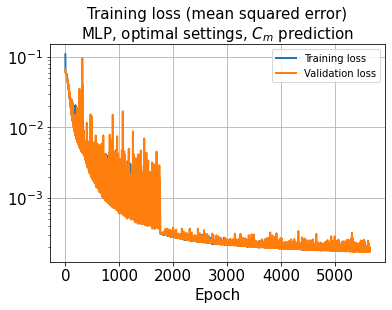

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

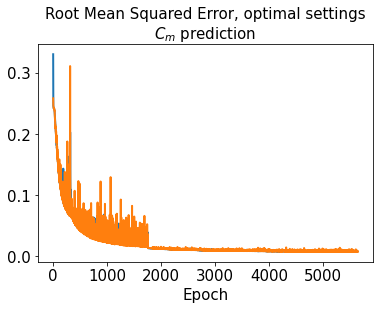

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

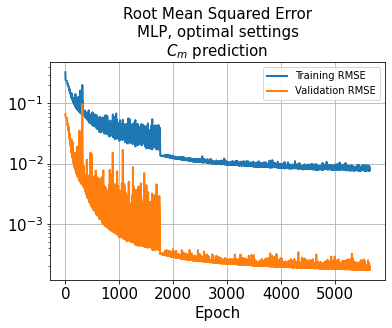

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.6736e-04 - rmse: 0.0072


In [38]:
val_results = model.evaluate(x_val, y_val)

375/375 [==============================] - 1s 3ms/step - loss: 1.7100e-04 - rmse: 0.0074


In [39]:
test_results = model.evaluate(x_test, y_test)

188/188 [==============================] - 1s 3ms/step - loss: 1.6536e-04 - rmse: 0.0071


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

188/188 [==============================] - 0s 1ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.016482038888691784
0.6713246716283517


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.017198580637029164
0.7041843897967668


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.016309960508839816
0.6681824974683704


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_12beta_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

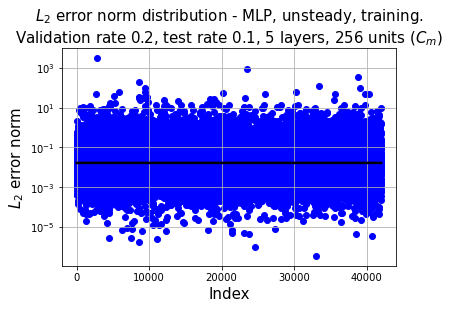

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

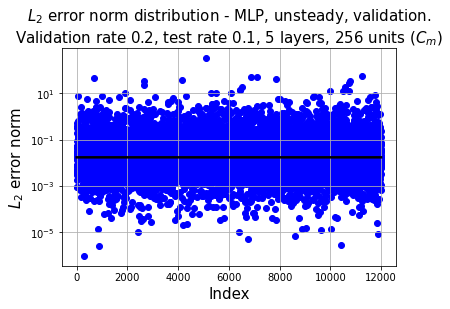

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

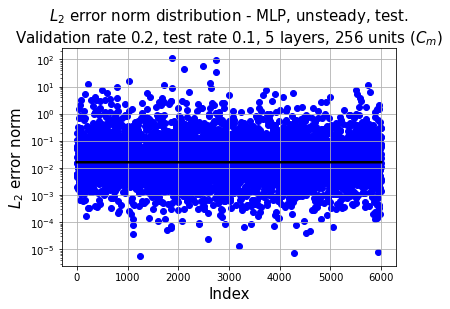

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

1875/1875 [==============================] - 3s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(42000,)

In [67]:
max(predicted)

array([1.0135753], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.022782530185882603

In [69]:
l2_error(predicted, y)

0.016609312504264184

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0126


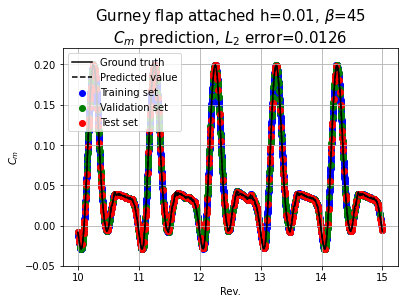

L2 error of Cm: 0.0166


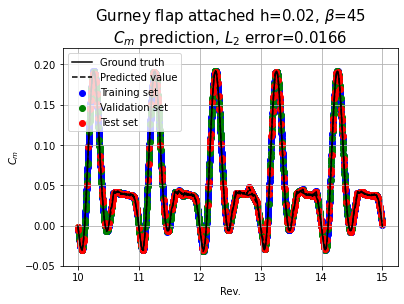

L2 error of Cm: 0.0191


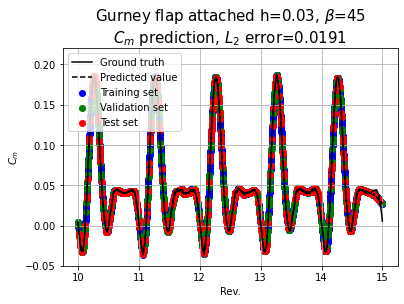

L2 error of Cm: 0.0143


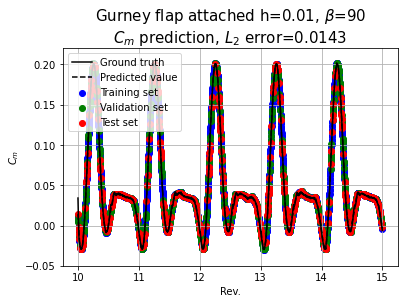

L2 error of Cm: 0.0111


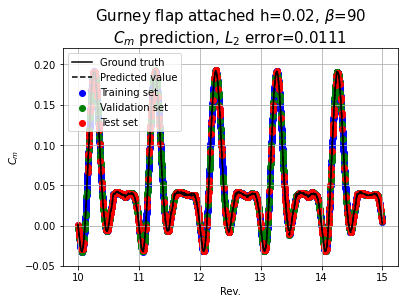

L2 error of Cm: 0.0148


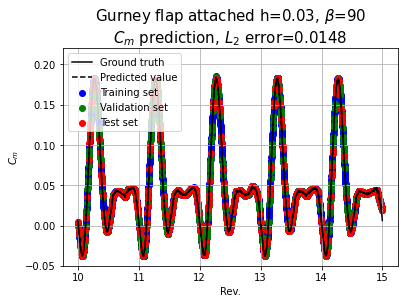

L2 error of Cm: 0.0219


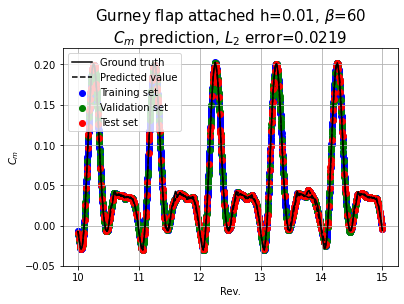

L2 error of Cm: 0.0161


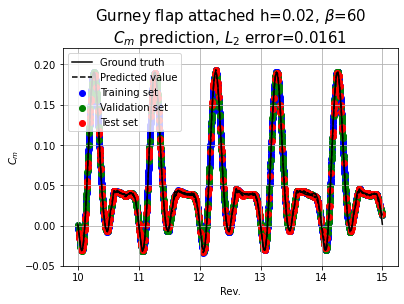

L2 error of Cm: 0.0112


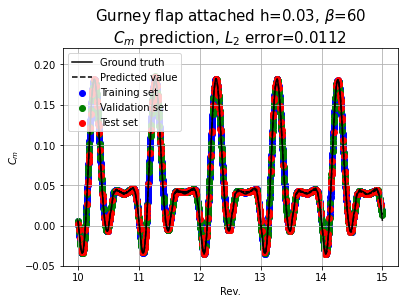

L2 error of Cm: 0.0147


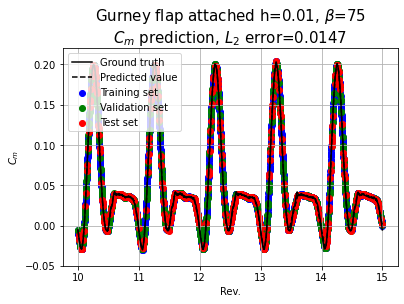

In [74]:
h = [0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [45, 45, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0,12):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [75]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0126


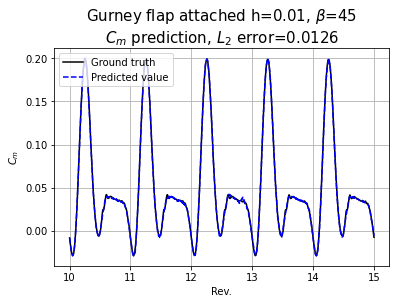

L2 error of Cm: 0.0166


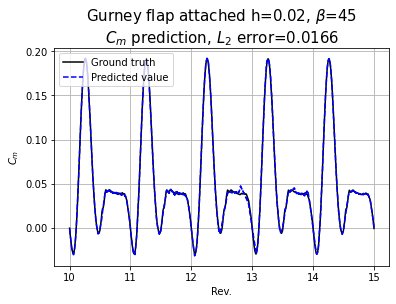

L2 error of Cm: 0.0191


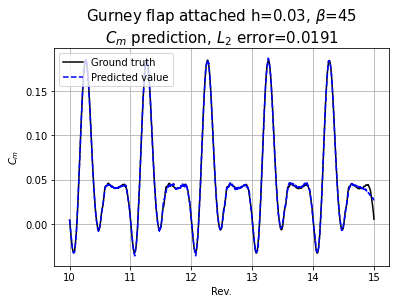

L2 error of Cm: 0.0143


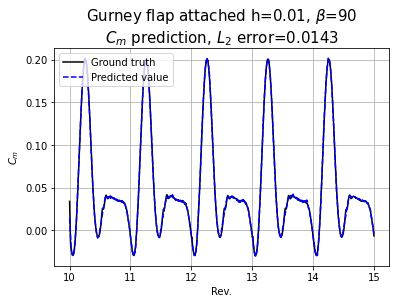

L2 error of Cm: 0.0111


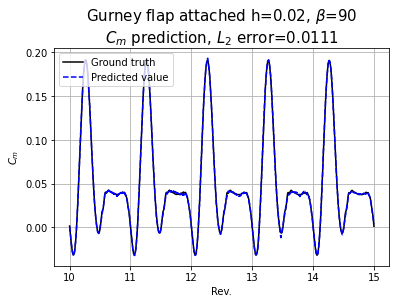

L2 error of Cm: 0.0148


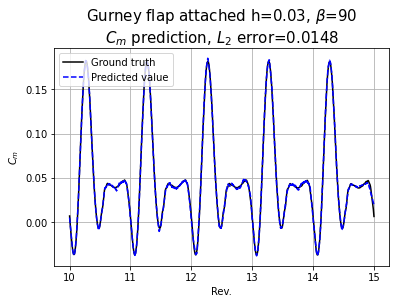

L2 error of Cm: 0.0219


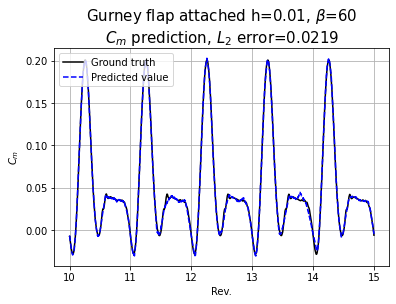

L2 error of Cm: 0.0161


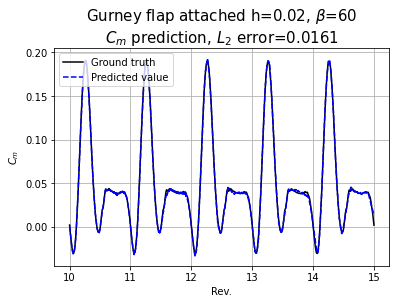

L2 error of Cm: 0.0112


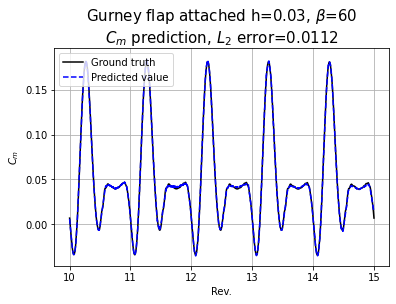

L2 error of Cm: 0.0147


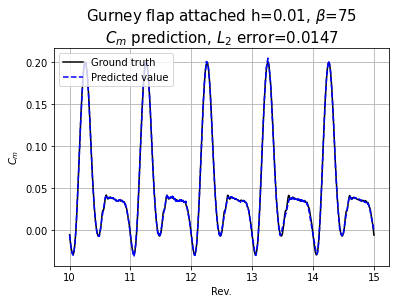

In [76]:
for i in range(0,12):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0126


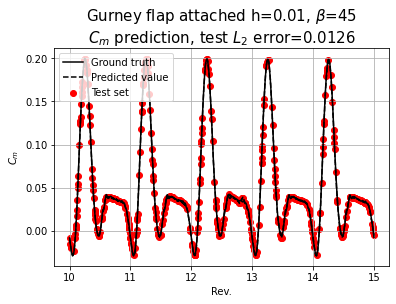

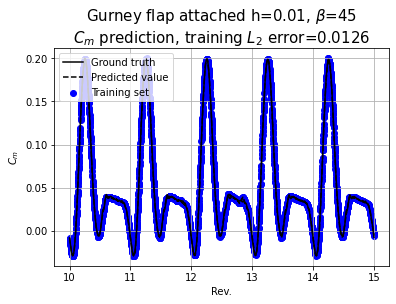

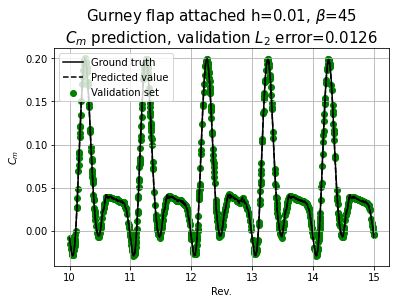

L2 error of Cm: 0.0166


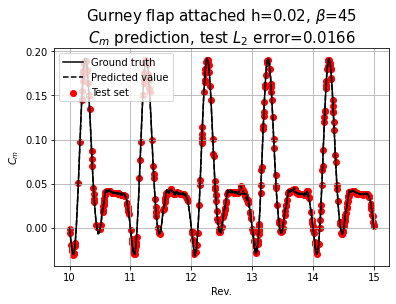

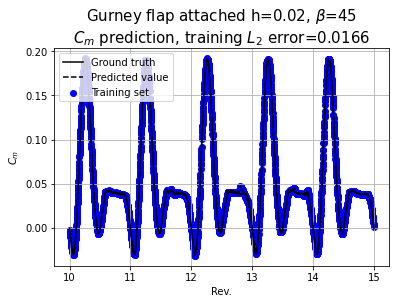

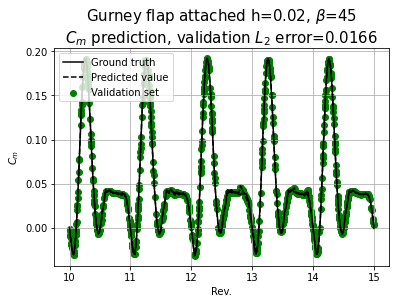

L2 error of Cm: 0.0191


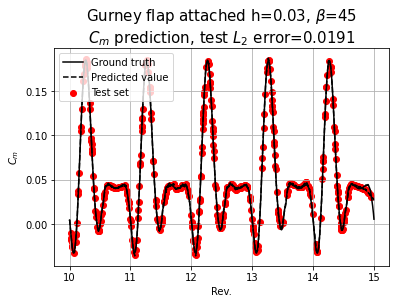

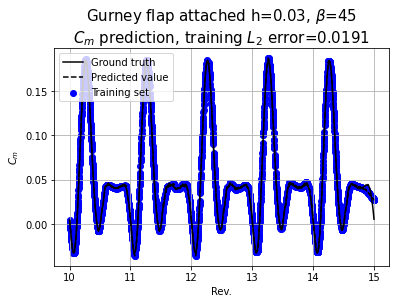

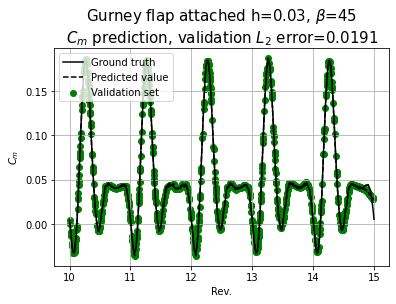

L2 error of Cm: 0.0143


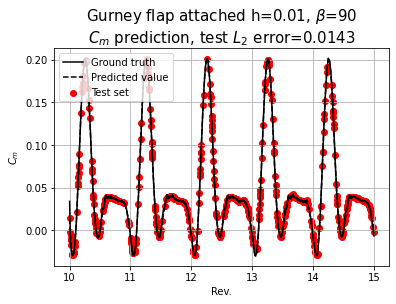

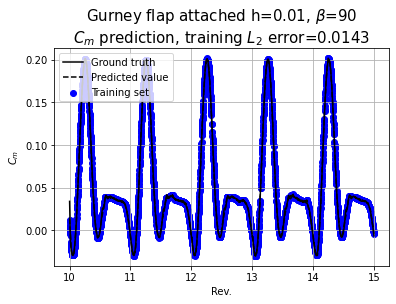

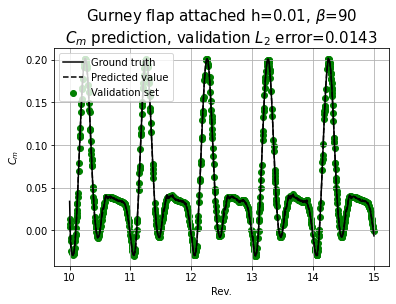

L2 error of Cm: 0.0111


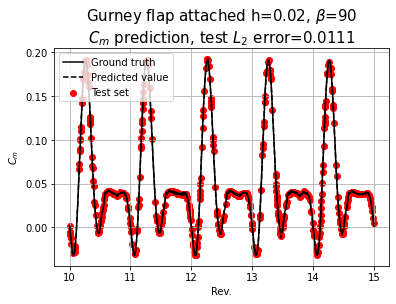

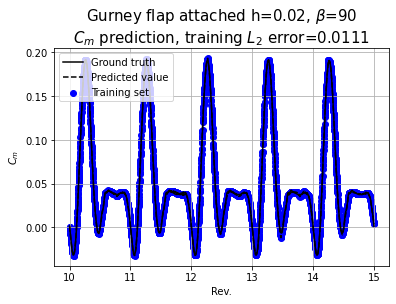

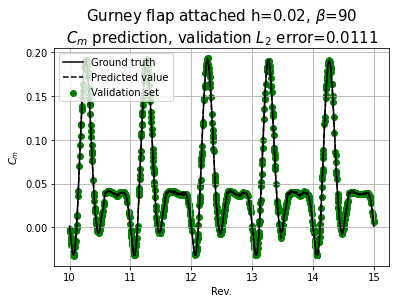

L2 error of Cm: 0.0148


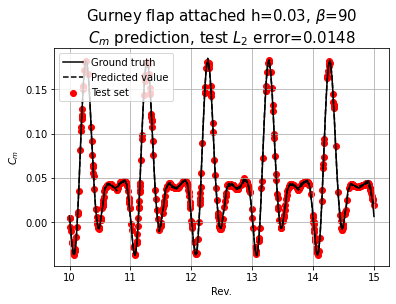

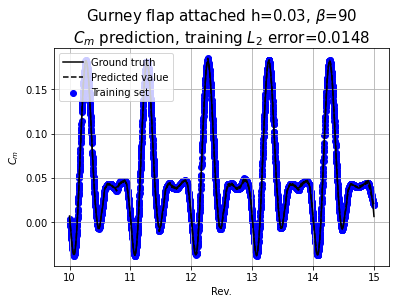

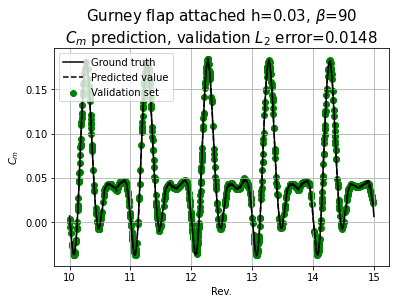

L2 error of Cm: 0.0219


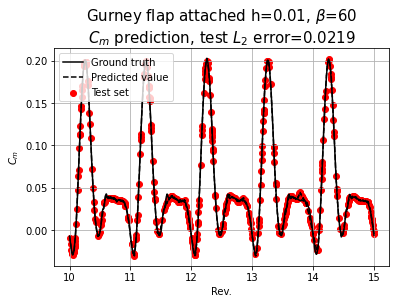

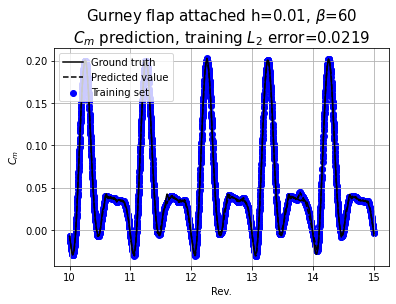

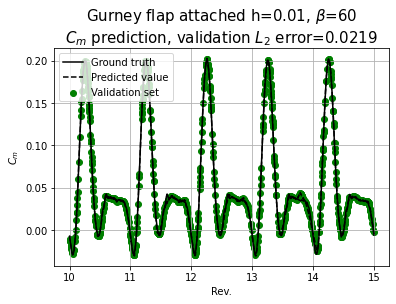

L2 error of Cm: 0.0161


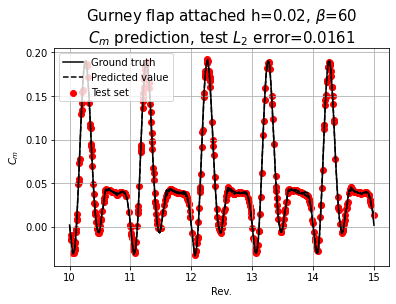

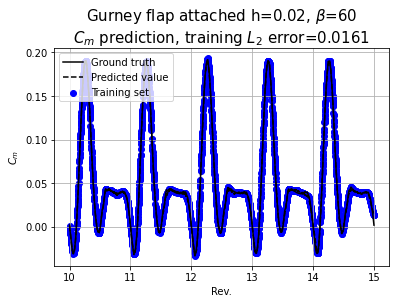

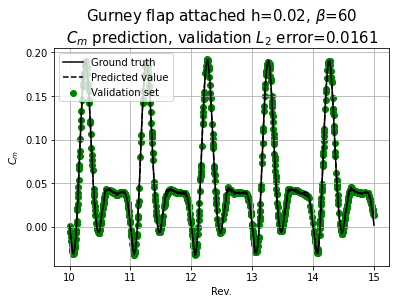

L2 error of Cm: 0.0112


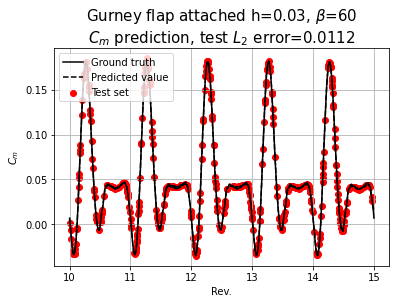

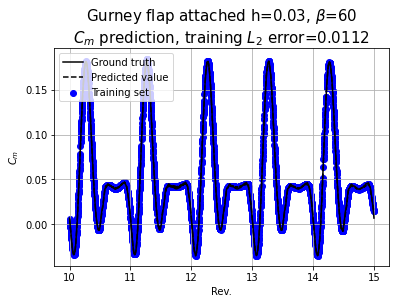

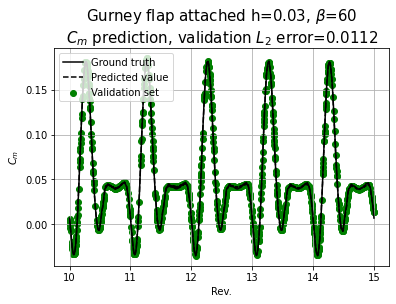

L2 error of Cm: 0.0147


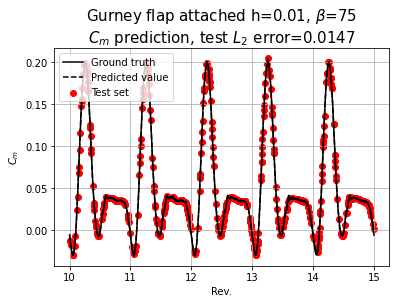

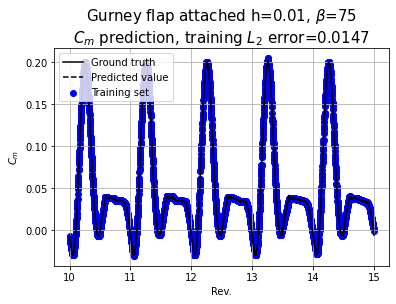

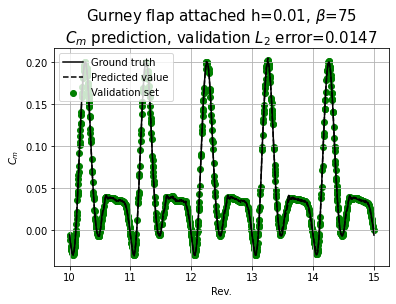

L2 error of Cm: 0.0154


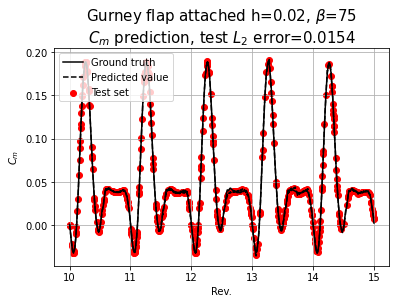

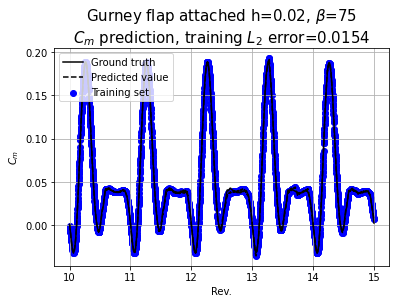

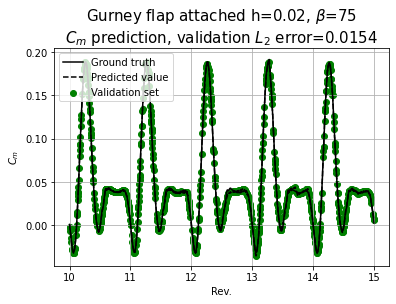

L2 error of Cm: 0.0256


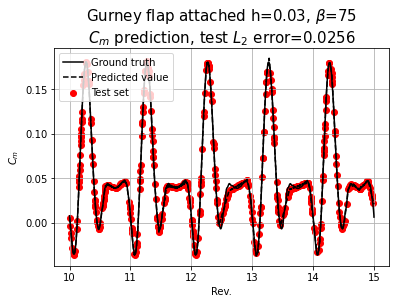

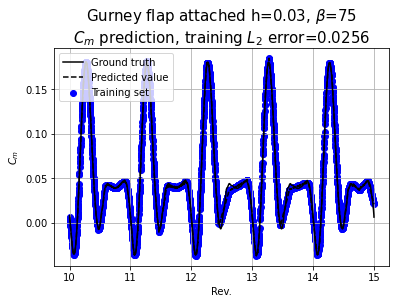

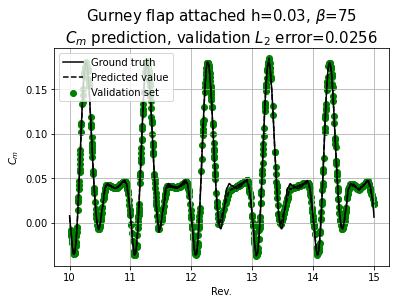

In [82]:
for i in range(0,12):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename3, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()